In [14]:
import pandas as pd
import numpy as np
import os
import joblib
import pickle

# --- PATHS ---
TEST_DATA_PATH = r"C:\Users\harip\Desktop\RideWise-Predicting-Bike-sharing-Demand\Data\dayTest.csv"
SAVE_MODEL_DIR = r"C:\Users\harip\Desktop\RideWise-Predicting-Bike-sharing-Demand\Modeling\saved_models"
SCALER_PATH = os.path.join(SAVE_MODEL_DIR, "DR_scaler.pkl")

# --- 1. Load and preprocess test set as before ---
df = pd.read_csv(TEST_DATA_PATH)
columns_to_drop = ['instant', 'casual', 'registered', 'dteday', 'atemp']
df = df.drop(columns=columns_to_drop)
df['weekend'] = ((df['weekday'] == 0) | (df['weekday'] == 6)).astype(int)

dependent_variable = 'cnt'
independent_variables = [col for col in df.columns if col != dependent_variable]
actual_cnt = df[dependent_variable].values


In [15]:
df.info()
df[independent_variables].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
 11  weekend     730 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 

In [16]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,weekend
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985,1
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801,1
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349,0
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562,0
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600,0


In [ ]:
import numpy as np
import pandas as pd
import joblib

# Assume df is your *full* test dataframe, not just a sample

# Prepare test features and target
actual_cnt = df[dependent_variable].values
X_full = df[independent_variables]

# Scale all features
with open(SCALER_PATH, 'rb') as f:
    scaler = pickle.load(f)
X_full_scaled = scaler.transform(X_full)

# Load all models
model_files = [f for f in os.listdir(SAVE_MODEL_DIR) if f.endswith('.pkl') and f != "DR_scaler.pkl"]
models = {file.replace('.pkl', ''): joblib.load(os.path.join(SAVE_MODEL_DIR, file)) for file in model_files}

# Predict on full dataset!
output_df_full = pd.DataFrame({'Actual_cnt': actual_cnt})
for name, model in models.items():
    y_pred_sqrt = model.predict(X_full_scaled)
    y_pred_cnt = np.round(y_pred_sqrt**2, 0)
    output_df_full[f"{name}_Pred"] = y_pred_cnt

# Now sample 10 random rows to display
np.random.seed(42)  # For reproducibility
sample_idx = np.random.choice(output_df_full.index, 10, replace=False)
output_df_sample = output_df_full.loc[sample_idx].reset_index(drop=True)
print(output_df_sample)


   Actual_cnt  decisiontree_Pred  elasticnet_Pred  gradientboost_Pred  \
0        7460             4935.0          13998.0              2070.0   
1        4788             3074.0           2564.0               806.0   
2        3331             3074.0              0.0               763.0   
3        3068             3074.0              0.0               814.0   
4        7338             4935.0         195708.0              2193.0   
5        5423             3074.0          15722.0               562.0   
6        2046             3074.0              0.0               904.0   
7        2121             3074.0              0.0               822.0   
8        3409             3074.0              0.0               663.0   
9        3620             3074.0              0.0               905.0   

   lasso_Pred  randomforest_Pred  ridge_Pred  
0     10108.0             4204.0     10522.0  
1       425.0             2192.0       850.0  
2         0.0             2218.0         0.0  
3       

## saving best model

In [34]:
from sklearn.metrics import mean_absolute_error
import joblib

# Dictionary to hold MAEs for each model
mae_scores = {}

# Loop over each model prediction column
for name in models:
    pred_col = f"{name}_Pred"
    # Calculate MAE
    mae = mean_absolute_error(output_df["Actual_cnt"], output_df[pred_col])
    mae_scores[name] = mae
    print(f"{name}: MAE = {mae:.2f}")

# Find the best model (lowest MAE)
best_model_name = min(mae_scores, key=mae_scores.get)
print(f"\nBest model: {best_model_name} (MAE={mae_scores[best_model_name]:.2f})")

# Save the best model for deployment
best_model = models[best_model_name]
best_model_path = os.path.join(SAVE_MODEL_DIR, "best_model.pkl")
joblib.dump(best_model, best_model_path)
print(f"Best model saved to: {best_model_path}")


best_model: MAE = 997.10
decisiontree: MAE = 997.10
elasticnet: MAE = 54151.70
gradientboost: MAE = 3231.10
lasso: MAE = 79672.50
randomforest: MAE = 1829.20
ridge: MAE = 93496.50

Best model: best_model (MAE=997.10)
Best model saved to: C:\Users\harip\Desktop\RideWise-Predicting-Bike-sharing-Demand\Modeling\saved_models\best_model.pkl


## Actual Vs Predicted value of Best model

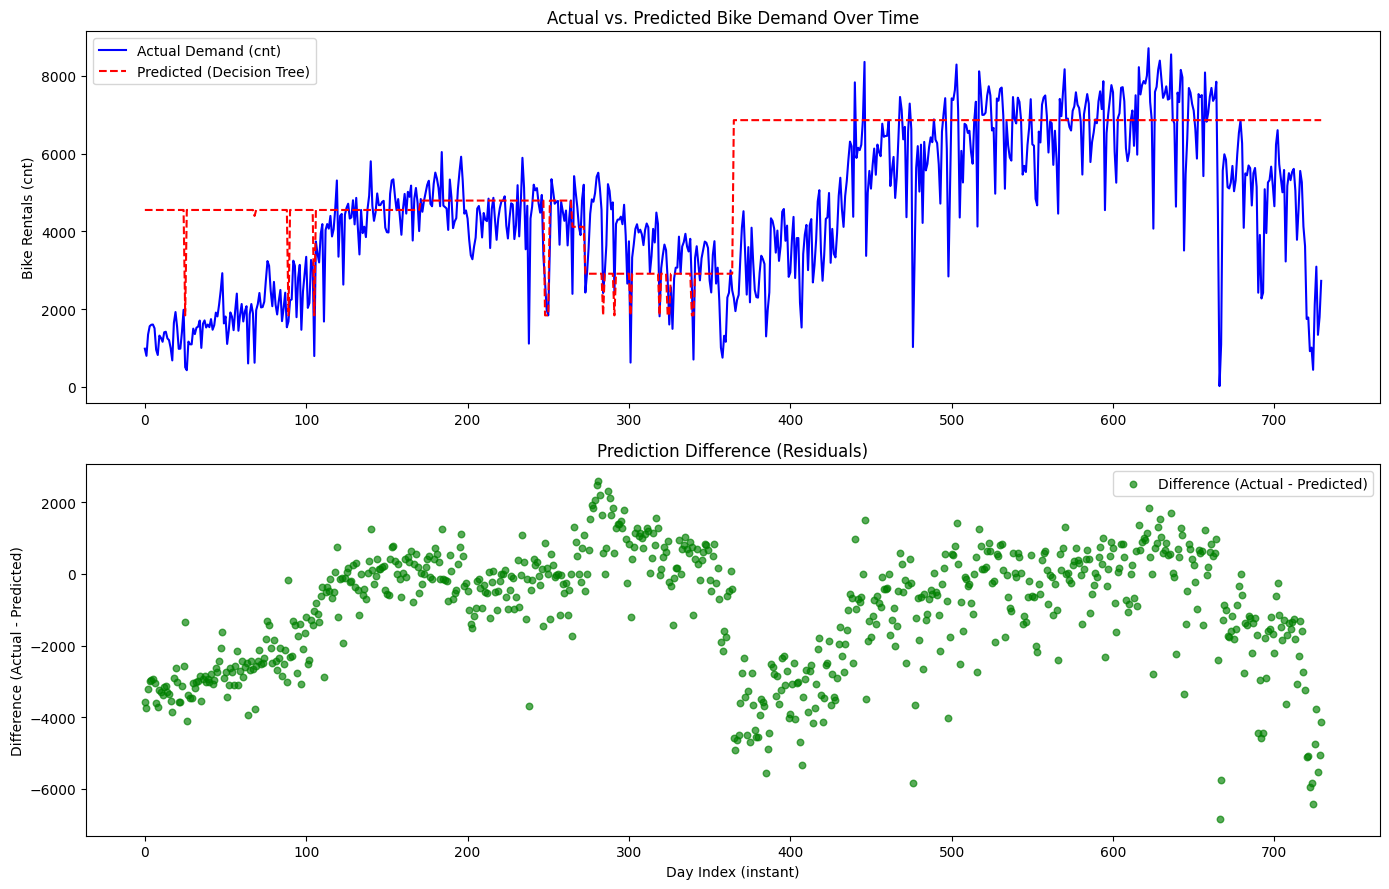

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on full dataset as above; assume output_df_full as below:
# output_df_full = pd.DataFrame({'Actual_cnt': actual_cnt, ...model predictions...})

# For Decision Tree model, get predictions:
decisiontree_pred = output_df_full['decisiontree_Pred'].values
actual_cnt = output_df_full['Actual_cnt'].values

# If you have 'instant' or date column in your original df, use it:
if 'instant' in df.columns:
    x_axis = df['instant'].values
else:
    x_axis = np.arange(len(actual_cnt))

# --- Top Plot: Actual vs. Predicted Demand Over Time ---
plt.figure(figsize=(14, 9))

plt.subplot(2, 1, 1)
plt.plot(x_axis, actual_cnt, label='Actual Demand (cnt)', color='blue')
plt.plot(x_axis, decisiontree_pred, label='Predicted (Decision Tree)', color='red', linestyle='--')
plt.ylabel('Bike Rentals (cnt)')
plt.title('Actual vs. Predicted Bike Demand Over Time')
plt.legend()

# --- Bottom Plot: Residuals Over Time ---
residuals = actual_cnt - decisiontree_pred

plt.subplot(2, 1, 2)
plt.scatter(x_axis, residuals, color='green', alpha=0.65, s=22, label='Difference (Actual - Predicted)')
plt.xlabel('Day Index (instant)')
plt.ylabel('Difference (Actual - Predicted)')
plt.title('Prediction Difference (Residuals)')
plt.legend()

plt.tight_layout()
plt.show()


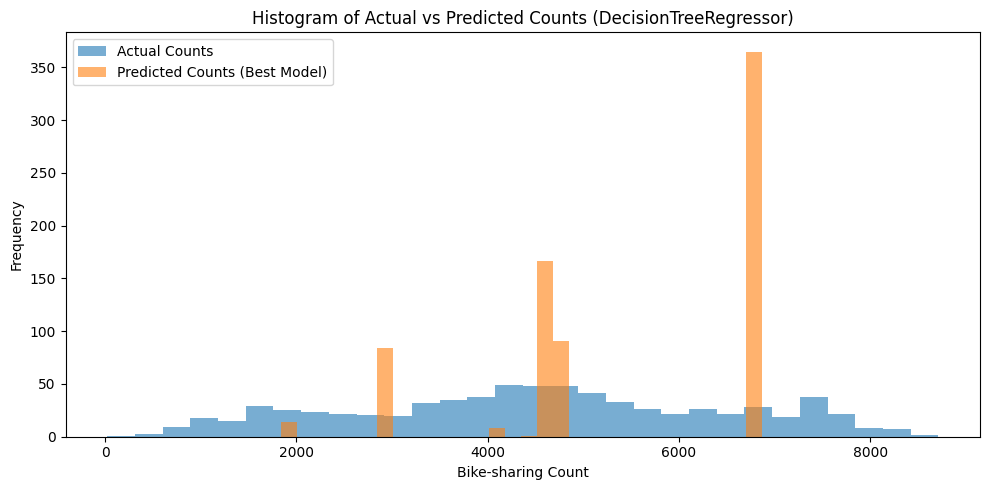

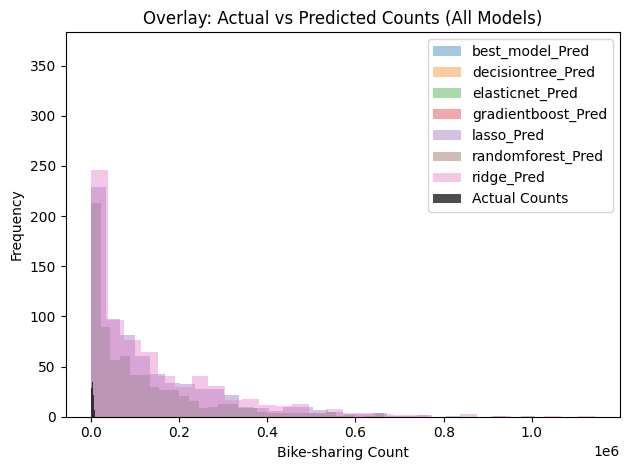

In [29]:
import matplotlib.pyplot as plt

# --- Histogram: Actual vs Predicted for best model ---
plt.figure(figsize=(10, 5))

plt.hist(y_test, bins=30, alpha=0.6, label='Actual Counts')
plt.hist(y_test_pred, bins=30, alpha=0.6, label='Predicted Counts (Best Model)')
plt.title(f'Histogram of Actual vs Predicted Counts ({best_model_name})')
plt.xlabel('Bike-sharing Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# --- Overlay predictions from other models (optional) ---
for name in models:  # Loop through all models you loaded
    y_pred = np.round(models[name].predict(X_test_scaled)**2, 0)
    plt.hist(y_pred, bins=30, alpha=0.4, label=f'{name}_Pred')

plt.hist(y_test, bins=30, alpha=0.7, label='Actual Counts', color='black')
plt.title('Overlay: Actual vs Predicted Counts (All Models)')
plt.xlabel('Bike-sharing Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()
